# Lab 4: Logistic Regression, SVM, Cross Validation
In this lab we will 
1. get some more practice with classification methods(Logistic Regression and Support Vector Machines)
2. explore validation methods that we covered in class this week and last.

We'll use the credit data from Assignment 2 for this lab.

## Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
%matplotlib inline

In [2]:
# Load data
fname = 'credit-data.csv'
df = pd.read_csv(fname)

In [3]:
# get counts
df.count()

PersonID                                41016
SeriousDlqin2yrs                        41016
RevolvingUtilizationOfUnsecuredLines    41016
age                                     41016
zipcode                                 41016
NumberOfTime30-59DaysPastDueNotWorse    41016
DebtRatio                               41016
MonthlyIncome                           33042
NumberOfOpenCreditLinesAndLoans         41016
NumberOfTimes90DaysLate                 41016
NumberRealEstateLoansOrLines            41016
NumberOfTime60-89DaysPastDueNotWorse    41016
NumberOfDependents                      39979
dtype: int64

# 1) Cleaning the dataset
A decent chunk of the columns are missing values. If you're using features that are missing values, you need to do something to take care of them(IE: drop those rows, fill in the missing value, add a new category that corresponds to missing value, etc).

Remember that a lot of these features are not operating at the same magnitude. A feature like 
Monthly Income has values on the order of $10^3$ while a feature like Number of times 90 days late is on the order of 10. So do some kind of feature normalization or bucketing to account for this.

## Important
Some data cleaning can happen on the entire data set and some needs to happen for each training and test set separately. You can write the code/function to do this here but you should not do this globally on the entire dataset. For example:
* imputation: any imputation requiring computation (mean or median for example) on a given data set should take place for each training set separately.
* discretization: same as imputation.

In [4]:
def show_nulls(df):
	return df.isna().sum().sort_values(ascending=False)

def fill_whole_df_with_mean(df):
    num_cols = len(df.columns)
    for i in range(0, num_cols):
        df.iloc[:,i] = fill_col_with_mean(df.iloc[:,i])
    return

def fill_col_with_mean(df):
	return df.fillna(df.mean())

In [5]:
show_nulls(df)

MonthlyIncome                           7974
NumberOfDependents                      1037
NumberOfTime60-89DaysPastDueNotWorse       0
NumberRealEstateLoansOrLines               0
NumberOfTimes90DaysLate                    0
NumberOfOpenCreditLinesAndLoans            0
DebtRatio                                  0
NumberOfTime30-59DaysPastDueNotWorse       0
zipcode                                    0
age                                        0
RevolvingUtilizationOfUnsecuredLines       0
SeriousDlqin2yrs                           0
PersonID                                   0
dtype: int64

In [6]:
from sklearn.preprocessing import scale

In [7]:
scale(df['age'])

/Users/xiangyu/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


array([ 0.22489849,  1.309887  , -0.04634863, ...,  1.51332234,
        1.37769878,  0.5639574 ])

## Split the data 
Split the data into a training set and a test set. We're assuming here that there is no time dimension here so we'll split the data by rows and not use any time variables into account.

In [17]:
from sklearn.model_selection import train_test_split
features = ['MonthlyIncome', 'DebtRatio', 'age', 'NumberOfTimes90DaysLate','NumberOfOpenCreditLinesAndLoans'] # Pick the features you want
df_features = df[features]
df_target = df['SeriousDlqin2yrs']
X_train, X_test, Y_train, Y_test = train_test_split(df_features, df_target, test_size=0.2)

In [18]:
fill_whole_df_with_mean(X_train)
fill_whole_df_with_mean(X_test)

/Users/xiangyu/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [19]:
from sklearn.preprocessing import scale
def scale_a_df(df, features_list):
    temp_scaled = scale(df[features_list])
    #return a DF
    return pd.DataFrame(temp_scaled, columns= df.columns)

In [20]:
X_train = scale_a_df(X_train, features)

In [21]:
X_test = scale_a_df(X_test, features)

# 2) Applying Logistic Regression

Ref: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

You'll notice that LogisticRegression takes a ton of parameters. We'll play around with the "penalty" and "C" parameters.
If we set the penalty parameter to ['l2'](http://mathworld.wolfram.com/L2-Norm.html), sklearn's LogisticRegression model solves the following minimization problem:

$$ \min_{\beta} ||\beta||_2 + C \sum_{i} \log ( -y_i (X_i^T \beta) +1)$$

Similarly, if we set the penalty parameter to ['l1'](http://mathworld.wolfram.com/L2-Norm.html), LogisticRegression will solve the following minimization problem:

$$\min_{\beta} ||\beta||_1 + C \sum_{i} \log ( -y_i (X_i^T \beta) +1)$$

where $$||\beta||_2 = \sqrt { \sum_{i} \beta_i^2 }$$ and $$||\beta||_1 =  \sum_{i} | \beta_i | $$ 

Try running logistic regression with both L1 and L2 penalties and a mix of C values with K-fold cross validation on the training set. If the K-fold cross validation takes too long, consider using a smaller subset of the data. Write a function to perform the cross validation over both penalties, and a range of C values (something like $10^{-2}, 10^{-1}, 1, 10, 10^2)$ is reasonable

Write a function that performs [KFold cross validation](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) over the training set. This function
should loop over penalty('l1' and 'l2') and C values.

In this cross validation function, you should only be dealing with the training set. Below is a sample of how I might structure my cross validation + parameter search loop.

In [13]:
# Here is an example of how I'd do this for linear regression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error # to evaluate how good/bad my model predictions are
N = 1000
X = np.random.random((N, 10))
Y = np.random.random(N)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
alphas = [10**i for i in range(-3, 3)]
splits = 5
kf = KFold(n_splits=splits)

results = {} # dict of model params -> model performance over the KFold cross validation
for fold_num, (train_idx, test_idx) in enumerate(kf.split(X_train)):
    x_split_train, x_split_test = X_train[train_idx], X_train[test_idx]
    y_split_train, y_split_test = y_train[train_idx], y_train[test_idx]
    
    for a in alphas:
        linreg = Ridge(alpha=a)
        linreg.fit(x_split_train, y_split_train)
        y_pred = linreg.predict(x_split_test)
        model_key = (a, ) # this will be a longer tuple for things with more parameters
        results[a] =  results.get(a, 0) + mean_squared_error(y_pred, y_split_test) / splits

for model, model_perf in results.items():
    # the MSE here is meaningless b/c we're fitting random noise to random noise.
    print("Model with params: {} | MSE: {:.2f}".format(model, model_perf))

Model with params: 0.001 | MSE: 0.09
Model with params: 0.01 | MSE: 0.09
Model with params: 0.1 | MSE: 0.09
Model with params: 1 | MSE: 0.09
Model with params: 10 | MSE: 0.09
Model with params: 100 | MSE: 0.09


For regression tasks, mean_squared_error is a sensible metric to evaluate on. 

For classification, we might not want to use accuracy if our dataset is a unbalanced. Instead we might use [roc_auc_score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score) or precision or recall at a certain threshold. Note that regardless of which you use, you should call predict_proba from the LogisticRegression object.

Write a function to do do cross validation over the parameters penalty and C with LogisticRegresion.

In [23]:
# cross validate + optimization for parameters

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import KFold

def find_right_paras_LR_pred_acc(X_train = X_train, Y_train = Y_train, pred_threshold = 0.7, penalty_list = ['l1', 'l2'], cvalues_list = [10**-5, 10**-2, 10**-1, 1, 10, 10**2, 10**5], k_folds_num = 5):
   
    # initialize KFolds
    kf = KFold(n_splits = k_folds_num)

    # dictionary of results
    results_LR = {}

    for fold_numb, (train_idx, test_idx) in enumerate(kf.split(X_train)):

        # split into k-folds
        x_split_train, x_split_test = X_train.iloc[train_idx], X_train.iloc[test_idx]
        y_split_train, y_split_test = Y_train.iloc[train_idx], Y_train.iloc[test_idx]

        # test for each combination of parameters
        for c_para in cvalues_list:
            for penalty_para in penalty_list:

                #initialize logistic regression object with combination of parameters
                logreg = LogisticRegression(penalty = penalty_para, C = c_para)

                #fit the algorithm with data
                logreg.fit(x_split_train, y_split_train)

                # generate evaluation, in this case, prediction
                y_pred = logreg.predict(x_split_test)

                # write results to dictionary

                model_key = (c_para,penalty_para)
                
                # dict.get(key[, default]) this reports the value for the given key, returning a default value of 0 if it's absent
                # in this case, what we want to do is take a mean of the MSE generated for each iteration of the k-fold.
                results_LR[model_key] =  results_LR.get(model_key, 0) + mean_squared_error(y_pred, y_split_test)/k_folds_num

    #print results
    for model, model_perf in results_LR.items():
        print("Model with params: {} | MSE: {:.5f}".format(model, model_perf))

    return

In [24]:
find_right_paras_LR_pred_acc()

Model with params: (1e-05, 'l1') | MSE: 0.16089
Model with params: (1e-05, 'l2') | MSE: 0.15900
Model with params: (0.01, 'l1') | MSE: 0.15586
Model with params: (0.01, 'l2') | MSE: 0.15747
Model with params: (0.1, 'l1') | MSE: 0.15104
Model with params: (0.1, 'l2') | MSE: 0.15165
Model with params: (1, 'l1') | MSE: 0.15028
Model with params: (1, 'l2') | MSE: 0.15052
Model with params: (10, 'l1') | MSE: 0.15025
Model with params: (10, 'l2') | MSE: 0.15025
Model with params: (100, 'l1') | MSE: 0.15025
Model with params: (100, 'l2') | MSE: 0.15025
Model with params: (100000, 'l1') | MSE: 0.15025
Model with params: (100000, 'l2') | MSE: 0.15025


What combination of C value and penalty gives the highest cross validation score? Now create new models that uses the penalty and C-value that performed the best(according to whatever criteria you decided on). Fit this fresh model on the entire training set, and evaluate it on the test set.

In [25]:
# C of 10 with L1 regularization seems to perform well, so let's choose that.
logreg = LogisticRegression(penalty = "l1", C = 10)
logreg.fit(X_train, Y_train)
y_pred = logreg.predict(X_test)
print(mean_squared_error(y_pred, Y_test))

0.15333983422720623


To really see the difference between L1 and L2 regularization, we need to take a closer look at the models they produced. Plot a histogram of the weight values of LogisticRegression models for each C value. You can access these weight coefficients via the coef\_ attribute in LogisticRegression. Do you notice anything interesting happening as the C value varies?

In [52]:
# Let's see how coefficients for L1 regularization change as C value varies
# Now, for L2 Regularization
c_values_list = [10**i for i in range(-5, 5)]
all_coefs = np.array([])
i = 0
for c_value in c_values_list:
    if i == 0:
        logreg = LogisticRegression(penalty = "l1", C = c_value)
        logreg.fit(X_train, Y_train)
        all_coefs = np.hstack([all_coefs,logreg.coef_[0]])
    else:
        logreg = LogisticRegression(penalty = "l1", C = c_value)
        logreg.fit(X_train, Y_train)
        all_coefs = np.vstack([all_coefs,logreg.coef_[0]])
    i += 1
pd.DataFrame(all_coefs)

,0,1,2,3,4
0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,-0.211597,0.086310,0.000000
3,-0.099978,0.000000,-0.433276,1.884150,0.009424
4,-0.312711,-0.017535,-0.458031,2.858796,0.074387
5,-0.339061,-0.020994,-0.460519,2.968019,0.081592
6,-0.341738,-0.021344,-0.460799,2.979225,0.082331
7,-0.342029,-0.021383,-0.460784,2.980370,0.082412
8,-0.342061,-0.021385,-0.460805,2.980383,0.082405
9,-0.342046,-0.021388,-0.460768,2.980532,0.082397


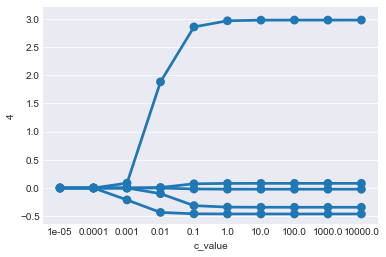

In [55]:
# transform to DF
coefs_df = pd.DataFrame(all_coefs)
coefs_df['c_value'] = c_values_list

# plot using seaborn
import seaborn as sns
sns.pointplot(x='c_value', y = 0, data = coefs_df)
sns.pointplot(x='c_value', y = 1, data = coefs_df)
sns.pointplot(x='c_value', y = 2, data = coefs_df)
sns.pointplot(x='c_value', y = 3, data = coefs_df)
sns.pointplot(x='c_value', y = 4, data = coefs_df)

In [56]:
# Now, for L2 Regularization
c_values_list = [10**i for i in range(-5, 5)]
all_coefs = np.array([])
i = 0
for c_value in c_values_list:
    if i == 0:
        logreg = LogisticRegression(penalty = "l2", C = c_value)
        logreg.fit(X_train, Y_train)
        all_coefs = np.hstack([all_coefs,logreg.coef_[0]])
    else:
        logreg = LogisticRegression(penalty = "l2", C = c_value)
        logreg.fit(X_train, Y_train)
        all_coefs = np.vstack([all_coefs,logreg.coef_[0]])
    i += 1
pd.DataFrame(all_coefs)

,0,1,2,3,4
0,-0.003002,-0.001535,-0.019153,0.015691,-0.004375
1,-0.018834,-0.007233,-0.115729,0.094455,-0.016734
2,-0.102008,-0.014903,-0.324363,0.333876,-0.005257
3,-0.273801,-0.018888,-0.445461,1.459337,0.041820
4,-0.334447,-0.020978,-0.459628,2.660956,0.074590
5,-0.341211,-0.021346,-0.460671,2.943179,0.081502
6,-0.341880,-0.021386,-0.460767,2.975787,0.082287
7,-0.341946,-0.021390,-0.460777,2.979100,0.082366
8,-0.341953,-0.021390,-0.460778,2.979432,0.082374
9,-0.341954,-0.021390,-0.460778,2.979465,0.082375


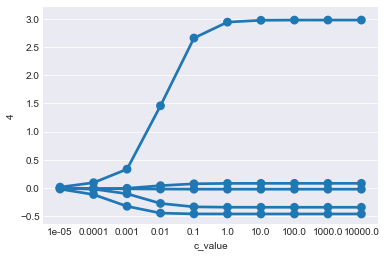

In [57]:
# transform to DF
coefs_df = pd.DataFrame(all_coefs)
coefs_df['c_value'] = c_values_list

# plot using seaborn
import seaborn as sns
sns.pointplot(x='c_value', y = 0, data = coefs_df)
sns.pointplot(x='c_value', y = 1, data = coefs_df)
sns.pointplot(x='c_value', y = 2, data = coefs_df)
sns.pointplot(x='c_value', y = 3, data = coefs_df)
sns.pointplot(x='c_value', y = 4, data = coefs_df)

It appears that the coefficients converge to zero as the C decreases.

You should see that the number of weight coefficients set to 0 in L1 regularized Logistic Regression increases with smaller C values. Revisit the minimization problems: you can think of the "C" parameter as a way of specifying the tradeoff between the L1/L2 penalty and the negative log likelihood of the model. A small value of "C" means that we are assigning greater weight to the L1/L2 penalty(equivalently downweighting the negative log likelihood).
**L1 regularization induces sparse models** - this can be a very useful if you suspect your classification target variable can be explained by few features.

Recall that a LogisticRegression model has a predict_proba function, so we can change our
classification threshold as we please. For tasks where a given class is extremely rare (IE: medical diagnoesis), you might have a very small number of positive examples(IE: patient has cancer). And you can artificially get a very high classification accuracy by simply predicting "No Cancer" for each patient. So instead of just using classification accuracy to see how good our model is, we'll consider precision and recall.

As a reminder, precision is defined as:
$$\text{precision} = \frac{TP}{TP + FP} $$
and recall is defined as:
$$ \text{recall} = \frac{TP}{TP + FN} $$

Complete the following functions to compute precision and recall.

In [90]:
def custom_predictions(clf, threshold = 0.7, x_test = X_test, y_test = Y_test):
    
    # generate array with predicted probabilities
    pred_array = clf.predict_proba(x_test)

    # initialize an empty array for the predictions
    pred_generated = np.array([])

    # predict the first entry
    if pred_array[0][0] >= threshold:
        pred_generated = np.hstack([pred_generated, 0])
    else:
        pred_generated = np.hstack([pred_generated, 1])

    # loops over the rest of the array
    for i in range(1,len(x_test)):
        if pred_array[i][0] >= threshold:
            pred_generated = np.vstack([pred_generated, 0])
        else:
            pred_generated = np.vstack([pred_generated, 1])

    # return an np.array
    return  pred_generated

In [95]:
pred_df = pd.DataFrame(custom_predictions(logreg, threshold= 0.7))
np.unique(pred_df, return_counts= True)

(array([0., 1.]), array([7754,  450]))

In [96]:
test = custom_predictions(logreg, threshold= 0.7)

In [128]:
def precision(y_pred, y_true):
    tp = 0
    fp = 0

    for i in range(0, len(y_pred)):
        if y_pred.iloc[i,0] == 1:
            if y_true.iloc[i] ==1:
                tp += 1
            else:
                fp += 1

    #calculate & return precision
    return (tp/(tp+fp))

def recall(y_pred, y_true):

    #initialize true positives and false negatives
    tp = 0
    fn = 0

    for i in range(0, len(y_pred)):
        # update tp if i is a true positive
        if y_pred.iloc[i,0] == 1 & y_true.iloc[i] == 1:
            tp += 1

        # update fn if i is a false negative
        if y_pred.iloc[i,0] == 0 & y_true.iloc[i] == 1:
            fn += 1

    return (tp/(tp+fn))

In [127]:
precision(pred_df, Y_test)

0.6133333333333333

In [129]:
recall(pred_df, Y_test)

1.0

LogisticRegression.predict uses 0.5 as the threshold for predicting True vs False. But a lower/higher probability threshold might give us better results. Try varying the classification probability thresholds and compute the precision and recall values and plot the [ROC curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) for the LogisticRegression model that performed the best. Also compute the [AUC](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score).

In [130]:
pred_array = custom_predictions(logreg, threshold= 0.7)

In [159]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt 

def plot_roc(pred_y, true_y, randomLine = True):
    # generate false postive rate and true positive rate
    fpr, tpr, thresholds = roc_curve(pred_y, true_y)
    # plot using matplotlib
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr,tpr)
    if randomLine:
        x = [0.0, 1.0]
        plt.plot(x, x, linestyle='dashed', color='red', linewidth=2, label='random')
    plt.show()
    return

def print_auc(pred_y, true_y):
    print('AUC Score: {}'.format(roc_auc_score(pred_y, true_y)))
    return

In [156]:
def try_thresholds_range(clf, thresh_list, x_test, y_test):
    # loop through list of threshold probabilities
    for i in thresh_list:     
        # generate predictions
        pred_y = custom_predictions(clf, threshold = i, x_test = x_test, y_test = y_test)
        # turn it into a DF because some of the helper functions I wrote require it
        pred_yDF = pd.DataFrame(pred_y)
        print('Threshold: {}'.format(i))
        print('Recall: {}'.format(recall(pred_yDF, y_test)))
        print('Precision: {}'.format(precision(pred_yDF, y_test)))
        print_auc(pred_y, y_test)
        plot_roc(pred_y, y_test)
    return 

In [154]:
threshold_range = [0.5,0.6,0.7,0.8,0.9]

Threshold: 0.5
Recall: 1.0
Precision: 0.7985611510791367
AUC Score: 0.8230251508650488


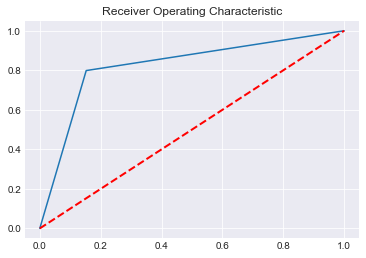

Threshold: 0.6
Recall: 1.0
Precision: 0.7607655502392344
AUC Score: 0.8064615743691481


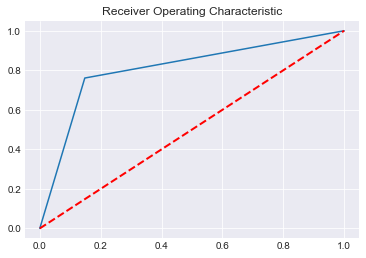

Threshold: 0.7
Recall: 1.0
Precision: 0.6133333333333333
AUC Score: 0.7379924340125527


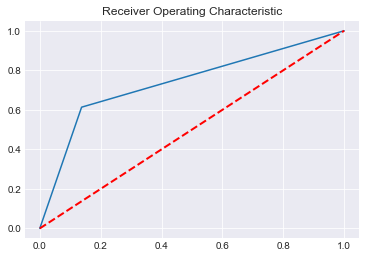

Threshold: 0.8
Recall: 1.0
Precision: 0.34315245478036177
AUC Score: 0.6175803747821094


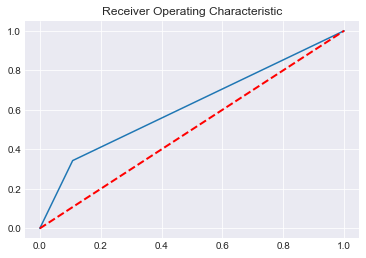

Threshold: 0.9
Recall: 1.0
Precision: 0.2007645005816852
AUC Score: 0.569975300130806


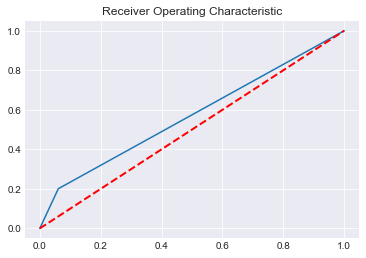

In [160]:
try_thresholds_range(logreg, threshold_range, X_test, Y_test)

# 3) Applying SVM

Ref: http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
The SVM Classifier also takes quite a few parameters. We will be playing with following parameters:
* C: same as above
* kernel: string, it can be one of 'rbf', 'poly', 'linear'. More on that below:
* gamma: parameter for the rbf kernel
* degree: int, optional(only used if the kernel is 'poly'
* coef0: float, optional(only used if the kernel is ‘poly’ or ‘sigmoid’)
* probability: **set it to true** (this boolean flag enables/disables probability estimates)

SVM tries to find the hyperplane that maximizes the "margin" between the two classes of points. The "C" parameter in [SVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) has the same role as the "C" parameter in LogisticRegression: it tells you how much to penalize the "size" of the weight vector. Note that SVC only allows for L2 regularization.

## Choosing the kernel
The kernels
* linear: $\langle x, x'\rangle$.
* polynomial: $(\gamma \langle x, x'\rangle + r)^d$. $d$ is specified by keyword degree, $r$ by coef0.
* rbf: $\exp(-\gamma \|x-x'\|^2)$.  $\gamma$ is specified by keyword gamma, must be greater than 0.
* sigmoid $(\tanh(\gamma \langle x,x'\rangle + r))$, where r is specified by coef0, and tanh is the [hyperbolic tangent](https://en.wikipedia.org/wiki/Hyperbolic_function#Definitions)

You should think of this kernel function as playing a similar role to what the distance metric  did in the KNN classifier. Fundamentally, SVM is trying to find a hyperplane that maximize some **geometric distance** between points of different classes, and this distance is determined by the kernel. So here it seems like there are many many free parameters to play with. To save a bit of time, the most important kernels to try out are: the linear, rbf kernel(with a few different gamma values). You should think about what a high/low gamma value does to the RBF kernel.

Write some code that computes the RBF kernel between two rows of the training set. Plot the rbf kernel between these two points with a few different values of gamma

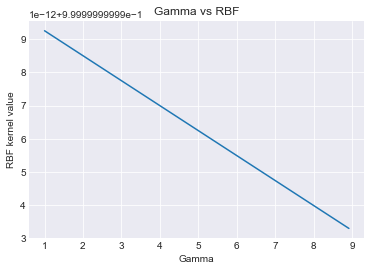

In [174]:
x1 = X_train.iloc[10,1] # any random training point
x2 = X_train.iloc[20,1] # any random training point that is not the same as x1
gammas = [10**i for i in np.arange(0, 1, 0.05)]

def rbf(x1, x2, gamma):
    from math import exp
    return exp(-1*gamma*((x1-x2)**2))

rbf_vals = [rbf(x1, x2, g) for g in gammas]
plt.plot(gammas, rbf_vals)
plt.title('Gamma vs RBF')
plt.xlabel('Gamma')
plt.ylabel('RBF kernel value')
plt.show()

In [ ]:
np.arange(-1, 1, 0.5)

As we did for LogisticRegression, write a function/some code to perform KFold crossvalidation on the training set to find the optimal C and kernel parameters. Repeat the cross validation after normalizing your continous features as well. Does normalization affect the SVM performance?

In [ ]:
from sklearn.svm import SVC
def cv_svm(**params):
    pass

The SVC classifier might take some time to train because it has to compute this square matrix of kernel values, which can be expensive for 30k points. If it's taking too long, you should subsample your data and try to fit the SVC model on this smaller subsample.

SVC also has a [predict_proba](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC.predict_proba) function, so let's also plot an ROC curve for your best performing SVC model.

Do you think SVM or LogisticRegression is better suited for this classification task?

## 4) Class Imbalance and Evaluation Metrics

As noted in lecture, accuracy is not necessarily the best way to evaluate your classifier. This is especially true in situations where
our classification dataset has class imbalance. In our current dataset, we have the following class proportions:

Both LogisticRegression and SVC have a class_weight parameter that allows you to specify how much the model should prefer correctly classifying one class over another. Try specifying this parameter in your models and see how this affects the evaluation metrics you just tried above. 

## Additional Questions
If you have the time, here are some additional things to try:
* pull in other features from the ACS api like demographic information of a given zipcode. Does this improve the models performance? Do you think this is an ethical thing to do for deciding loan applications?
* you've written a cv_logistic_regression function and a cv_svm function which probably look very similar. Try writing a cross validation function that takes a model(IE: LogisiticRegression, SVC, DecisionTreeClassifier) as a parameter as well so that we can just do cv_model(SVC, ....) and cv_model(LogisticRegression, ...)

##### 